# Research of advertisements for the sale of apartments
Data is from the Yandex.Realty service - an archive of advertisements for the sale of apartments in St. Petersburg and neighboring settlements for several years. Objective: learn how to determine the market value of real estate and set the parameters to ultimately build an automated system to track anomalies and fraudulent activity.

For each apartment for sale, two types of data are available. The first ones are entered by the user, the second ones are obtained automatically based on cartographic data. For example, the distance to the center, airport, nearest park and pond.

**Data Description**
- airports_nearest — distance to the nearest airport in meters (m)
- balcony — number of balconies
- ceiling_height — ceiling height (m)
- cityCenters_nearest — distance to the city center (m)
- days_exposition - how many days the ad was posted (from publication to removal)
- first_day_exposition — publication date
- floor - apartment floor
- floors_total - total floors in the house
- is_apartment - boolean
- kitchen_area - kitchen area in square meters (m²)
- last_price — price at the time of removal from publication
- living_area - living area in square meters (m²)
- locality_name — name of the locality
- open_plan - boolean
- parks_around3000 — number of parks within a 3 km radius
- parks_nearest — distance to the nearest park (m)
- ponds_around3000 — number of ponds within a 3 km radius
- ponds_nearest — distance to the nearest body of water (m)
- rooms — number of rooms
- studio - boolean
- total_area — total area of the apartment in square meters (m²)
- total_images — number of photos of the apartment in the ad

## 1. Data overview

In [1]:
import pandas as pd

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

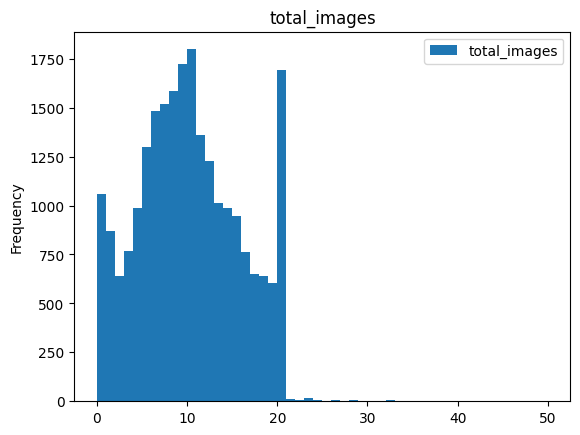

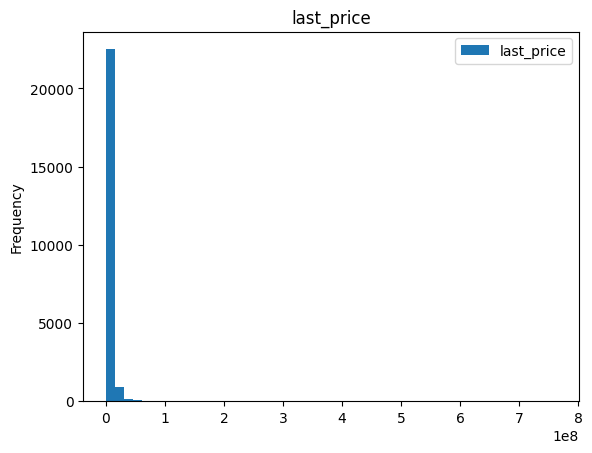

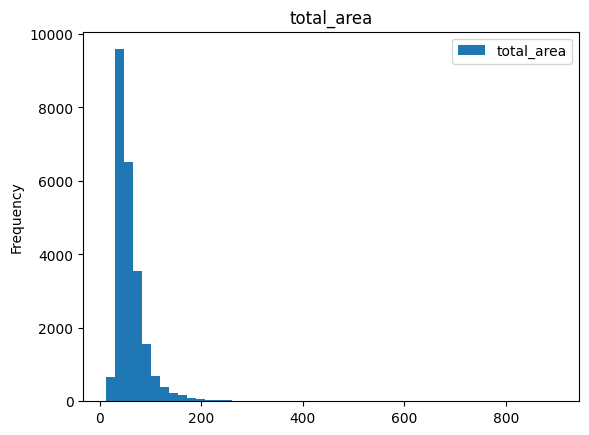

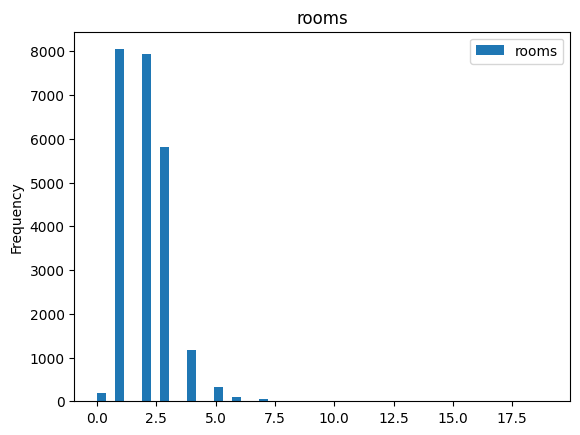

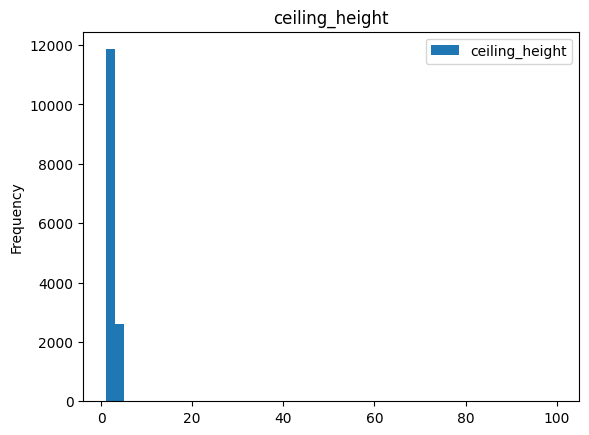

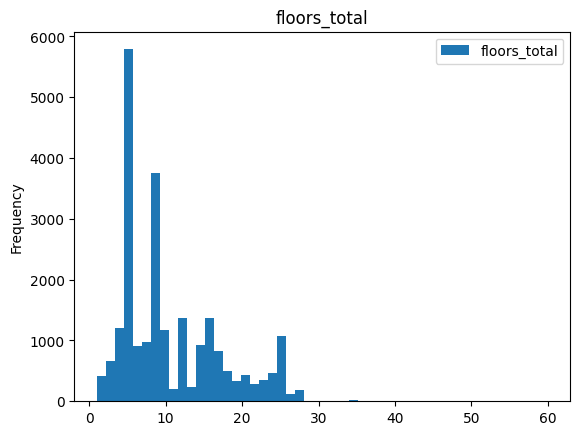

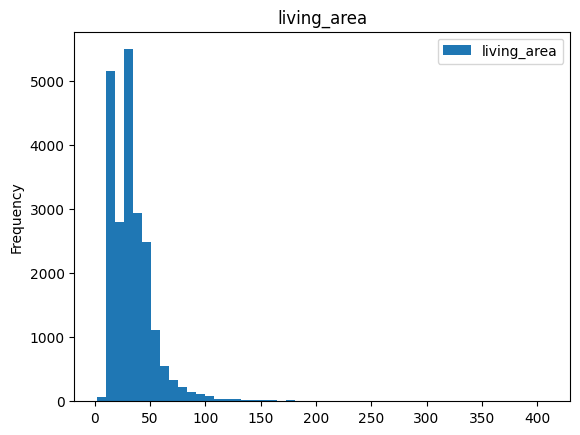

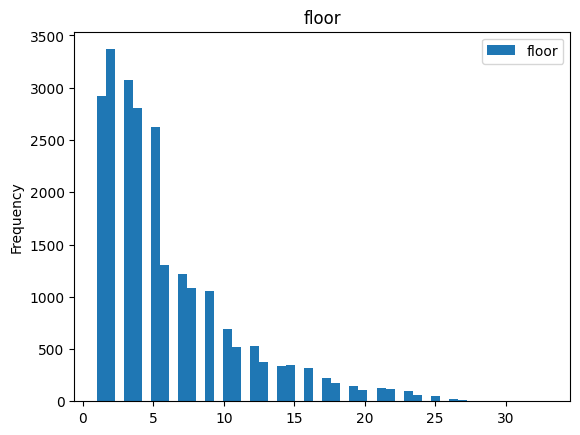

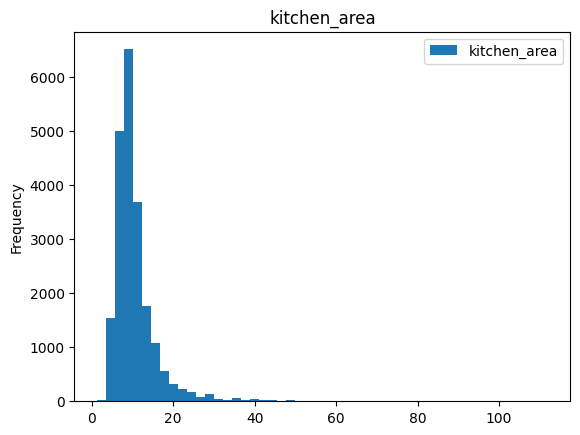

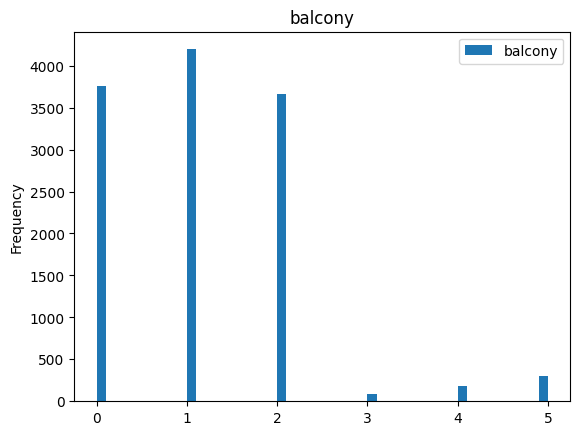

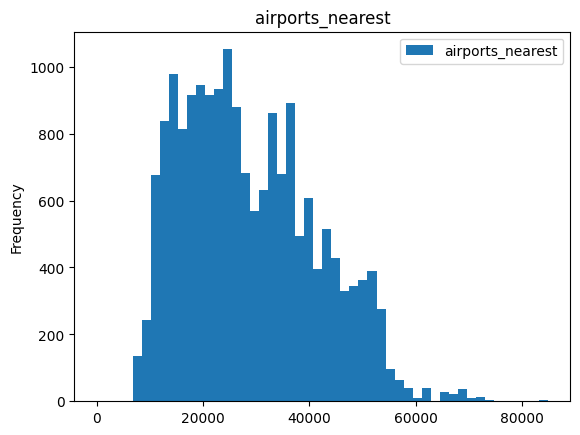

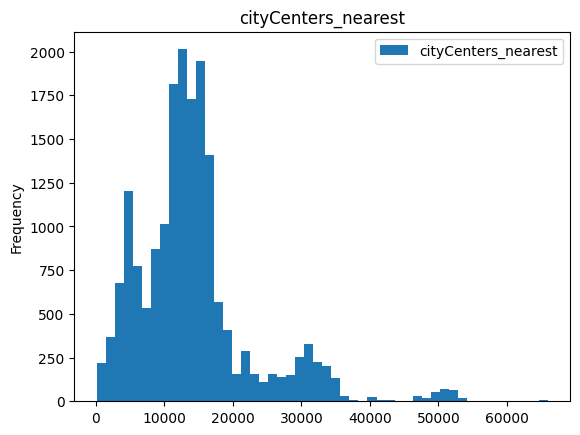

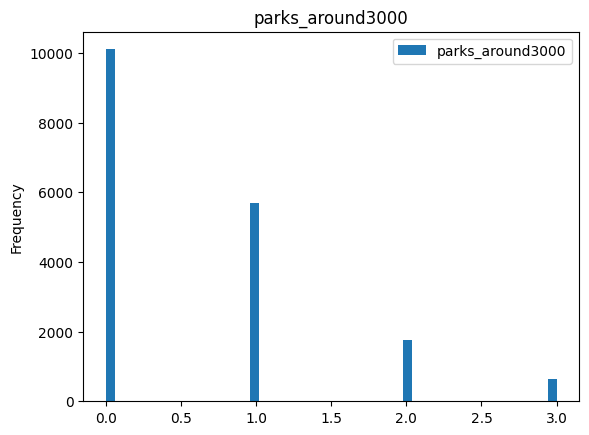

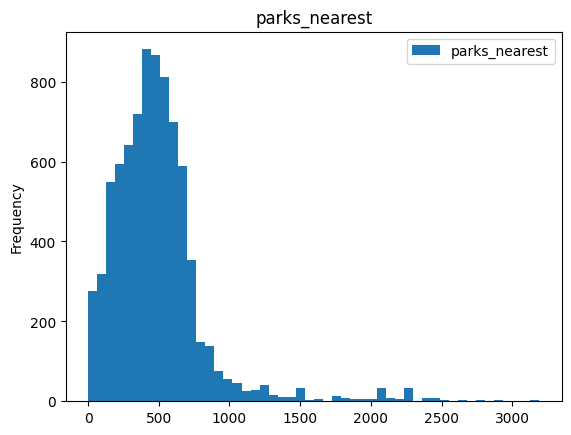

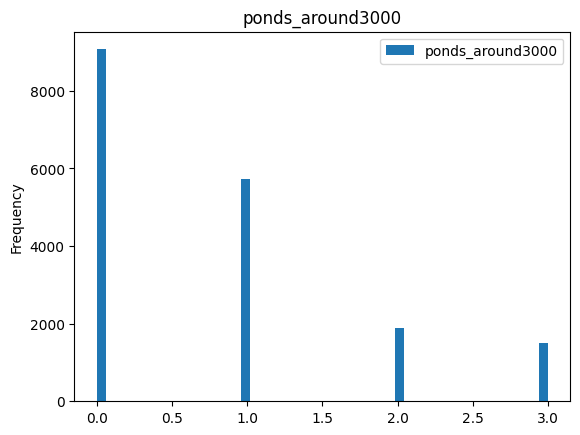

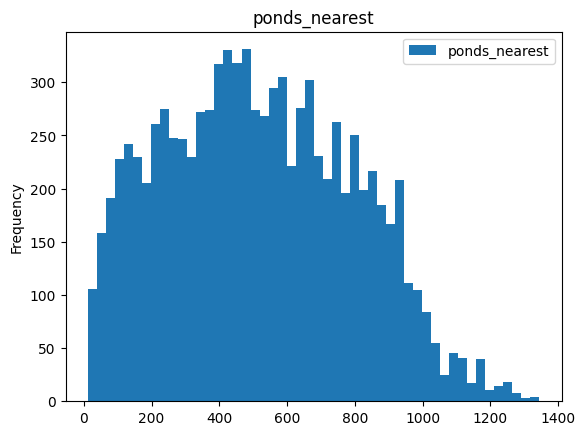

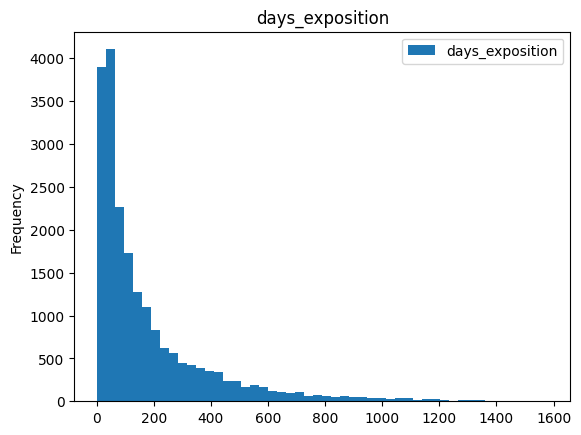

In [2]:
pd.options.display.max_columns = None
data = pd.read_csv('D:\\Jupyter\\real_estate_data.csv',sep='\t')
display(data.head())
data.info()
for column in data.columns:
    if data[column].dtypes in ['int64','float64']:
        data.plot(y=column,kind='hist',bins=50,title=column)

## 2. Data preprocessing
### 2.1. Missing values

In [3]:
pd.DataFrame(data.isna().mean()*100,).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.799105
floors_total,0.362885
living_area,8.029875
floor,0.000000
is_apartment,88.290645


There are no gaps in 'total_images', 'last_price', 'total_area', 'first_day_exposition', 'rooms', 'floor', 'studio', 'open_plan'. There are gaps in the remaining columns.

There is no information about the ceiling height in almost half of the cases; such a volume of data cannot simply be filled in with the median value.

There are few missing values in 'floors_total'; let’s fill them with values of 'floor' that do not have gaps.

We will fill in the gaps in 'living_area' with the median value.

In [4]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])
print(data['living_area'].median(), 'median living_area')
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
print('Unique living_area values:', data['is_apartment'].unique())
print('Sum of True living_area:', sum(data['is_apartment'] == True))
display(data['kitchen_area'].describe())
data['days_exposition'].describe()

30.0 median living_area
Unique living_area values: [nan False True]
Sum of True living_area: 50


count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

The vast majority of 'is_apartment' values are empty, the rest are bool and only 50 True values. An insignificant column that can be ignored. Let's replace missing data with False.

Missing balconies are filled with zero.

'locality_name' is categorical data, fill with blanks.

All other data was filled in automatically

Nearby airports and city centers do not need to be filled as there are none.

In [5]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('')
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
print(data.query('parks_around3000 > 0 & parks_nearest.isna()'))
print(data.query('ponds_around3000 > 0 & ponds_nearest.isna()'))

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []


There are no parks or ponds in the 'around3000' column, when they are not in the 'nearest' column, no filling is required.
### 2.2. Data types

In [6]:
display(data.head())
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
for column in ['floors_total','balcony','parks_around3000','ponds_around3000']:
    data[column] = data[column].astype('int64')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,30.0,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.0,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


### 2.3. Duplicates

In [7]:
data.duplicated().sum()

0

In [8]:
data.loc[data['locality_name'] == 'городской посёлок Янино-1','locality_name'] = 'городской поселок Янино-1'
data.loc[data['locality_name'] == 'деревня Кудрово','locality_name'] = 'Кудрово'
data.loc[data['locality_name'] == 'Любань','locality_name'] = 'поселок Любань'
data.loc[data['locality_name'] == 'посёлок Мурино','locality_name'] = 'поселок Мурино'
data.locality_name = data.locality_name.replace({'ё':'е'}, regex=True)
data['locality_name'] = data['locality_name'].apply(lambda x: x.replace('городской поселок', 'поселок')
                                                      .replace('поселок городского типа', 'поселок')
                                                      .replace('коттеджный поселок', 'поселок')
                                                      .replace('поселок при железнодорожной станции', 'поселок станции'))
data['locality_name'].sort_values().unique()

array(['', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Мурино', 'Никольское', 'Новая Ладога',
       'Отрадное', 'Павловск', 'Петергоф', 'Пикалево', 'Подпорожье',
       'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск',
       'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой',
       'Тихвин', 'Тосно', 'Шлиссельбург', 'деревня Агалатово',
       'деревня Аро', 'деревня Батово', 'деревня Бегуницы',
       'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка', 'де

### 2.4. Outlying values

In [9]:
data['ceiling_height'].sort_values(ascending=False).head()

22869    100.0
22336     32.0
3148      32.0
21377     27.5
20478     27.0
Name: ceiling_height, dtype: float64

Let's replace all values greater than 10 with median

In [10]:
print(data.loc[data['ceiling_height'] > 10,'ceiling_height'].count(), 'values changed')
data.loc[data['ceiling_height'] > 10,'ceiling_height'] = data['ceiling_height'].median()
data['ceiling_height'].sort_values(ascending=False).head()

25 values changed


5863     8.3
17442    8.0
3474     8.0
15743    8.0
20264    6.0
Name: ceiling_height, dtype: float64

In [11]:
display('Top 5 total images', data.sort_values(by='total_images',ascending=False).head())
display('Top 5 last price', data.sort_values(by='last_price',ascending=False).head())
display('Top 5 total area', data.sort_values(by='total_area',ascending=False).head())
display('Entries with floor, more than total floors', data.query('floor > floors_total'))
display('Entries with living area, more than total area', data.query('living_area > total_area'))
display('Entries with kitchen area, more than total area', data.query('kitchen_area > total_area'))

'Top 5 total images'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12667,50,20500000.0,76.0,2017-12-10,3,NaN,20,47.0,16,False,False,False,29.0,0,Санкт-Петербург,50812.0,16141.0,0,NaN,0,NaN,5.0
9778,50,11000000.0,87.0,2017-10-25,2,NaN,25,32.5,11,False,False,False,31.0,5,Санкт-Петербург,9586.0,11649.0,0,NaN,0,NaN,3.0
17396,50,14500000.0,119.7,2017-12-02,4,4.0,4,87.5,3,False,False,False,13.5,0,Санкт-Петербург,24375.0,2410.0,1,551.0,2,617.0,106.0
15157,42,17998000.0,138.6,2017-09-27,4,NaN,18,93.1,17,False,False,False,16.0,2,Санкт-Петербург,34991.0,11920.0,0,NaN,0,NaN,172.0
1058,39,1900000.0,63.0,2017-09-29,3,NaN,5,44.2,5,False,False,False,6.3,1,деревня Лопухинка,NaN,NaN,0,NaN,0,NaN,106.0


'Top 5 last price'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10,250.0,10,False,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33.0
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393.0
1436,19,330000000.0,190.0,2018-04-04,3,3.5,7,95.0,5,False,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233.0
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7,258.0,5,False,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0


'Top 5 total area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0
12859,20,140000000.0,631.2,2019-04-09,7,3.9,4,322.3,4,False,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5,30.0,5,False,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18,7,3.4,7,258.0,5,False,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0
5358,20,65000000.0,590.0,2019-02-14,15,3.5,6,409.0,3,False,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14.0


'Entries with floor, more than total floors'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


'Entries with living area, more than total area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
322,6,2000000.0,25.0,2017-02-07,1,NaN,5,30.0,5,False,False,False,NaN,0,Выборг,NaN,NaN,0,NaN,0,NaN,45.0
546,0,6000001.0,25.0,2018-11-16,1,3.00,5,30.0,5,False,False,False,NaN,0,Санкт-Петербург,25169.0,3871.0,1,207.0,1,776.0,17.0
608,2,1850000.0,25.0,2019-02-20,0,NaN,10,30.0,7,False,True,False,NaN,0,поселок Шушары,NaN,NaN,0,NaN,0,NaN,29.0
780,9,2600000.0,26.1,2018-02-20,0,NaN,18,30.0,8,False,False,True,NaN,1,поселок Мурино,NaN,NaN,0,NaN,0,NaN,45.0
1053,13,550000.0,29.0,2018-02-01,1,5.00,3,30.0,1,False,False,False,NaN,0,Бокситогорск,NaN,NaN,0,NaN,0,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22356,6,2050000.0,17.2,2019-01-13,1,2.77,23,30.0,1,False,False,False,NaN,0,Санкт-Петербург,33645.0,13513.0,0,NaN,0,NaN,7.0
22661,6,3150000.0,24.0,2019-04-16,1,NaN,5,30.0,3,False,False,False,NaN,0,Санкт-Петербург,26737.0,5235.0,1,359.0,1,964.0,NaN
22839,14,3350000.0,27.0,2018-11-03,1,2.70,16,30.0,6,False,False,False,4.0,2,Санкт-Петербург,41935.0,9551.0,0,NaN,0,NaN,35.0
23500,7,2850000.0,29.0,2018-02-11,1,NaN,9,30.0,9,False,False,False,NaN,0,Санкт-Петербург,26953.0,12051.0,0,NaN,0,NaN,45.0


'Entries with kitchen area, more than total area'

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


There are a few apartments with a lot of photos, but that doesn't mean the values aren't realistic. Maybe someone has such a hobby.

There are several apartments with great prices. Everything is in St. Petersburg, so...

There are several apartments with a large total area. All in St. Petersburg, all with the same prices, so...

There are no apartments where 'floor' is greater than 'floors_total'.

There are several apartments where 'living_area' is larger than 'total_area'. Let's reduce 'living_area' there to 'total_area' - 'kitchen_area'

There are no apartments where 'kitchen_area' is larger than 'total_area'.

In [12]:
data.loc[data['living_area'] > data['total_area'],'living_area'] = data['total_area'] - data['kitchen_area']

Overall: 'ceiling_height' and 'is_apartment' drew attention. In the first one, almost half of the values are missing; it is worth checking the data. The second one is practically insignificant and should either be deleted, or the process of information collection for it should be improved. Minor issues in several other columns have been corrected.
### 2.5. New columns
Adding 'area_price', price/area; type of floor; distance to city center in km

In [13]:
data['area_price'] = data['last_price'] / data['total_area']
def def_type(data_row):
    if data_row['floor'] == 1:
        return 'first'
    elif data_row['floor'] == data_row['floors_total']:
        return 'last'
    else:
        return 'other'
data['floor_type'] = data.apply(def_type,axis=1)
data['city_center_dist'] = (data['cityCenters_nearest'] / 1000).round().astype('Int64')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area_price,floor_type,city_center_dist
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,other,16
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,first,19
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,other,14
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.0,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,other,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,other,8


## 3. Exploratory data analysis
### 3.1. Studying object parameters

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


<Axes: title={'center': 'total_area'}, ylabel='Frequency'>

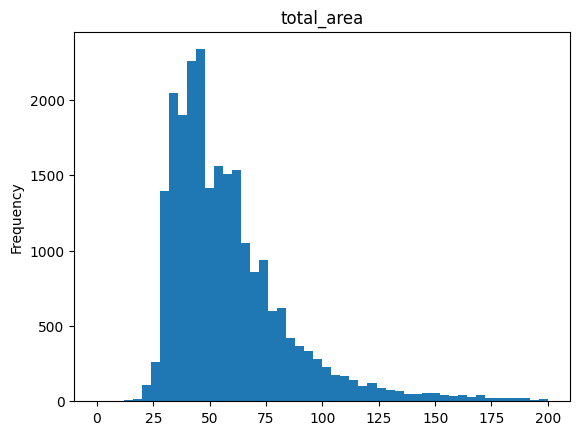

In [14]:
print(data['total_area'].describe())
data.plot(y='total_area',kind='hist',bins=50,title='total_area',range=(0,200),legend=False)

The appearance of the histogram did not change after removing missing values. Normal distribution.

count    23626.000000
mean        34.111264
std         21.194028
min          2.000000
25%         19.000000
50%         30.000000
75%         41.200000
max        409.700000
Name: living_area, dtype: float64


<Axes: title={'center': 'living_area'}, ylabel='Frequency'>

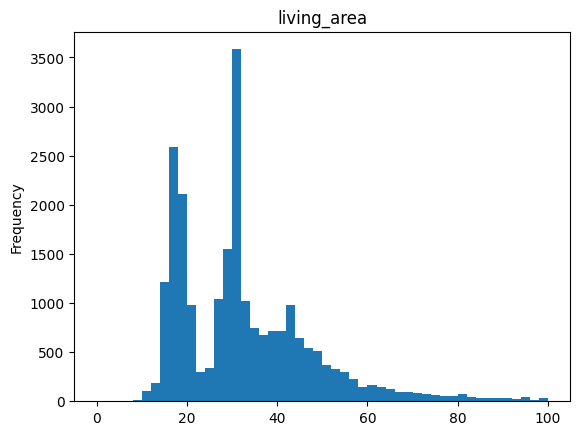

In [15]:
print(data['living_area'].describe())
data.plot(y='living_area',kind='hist',bins=50,title='living_area',range=(0,100),legend=False)

Two peaks stand out, both are included in the normal distribution.

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


<Axes: title={'center': 'kitchen_area'}, ylabel='Frequency'>

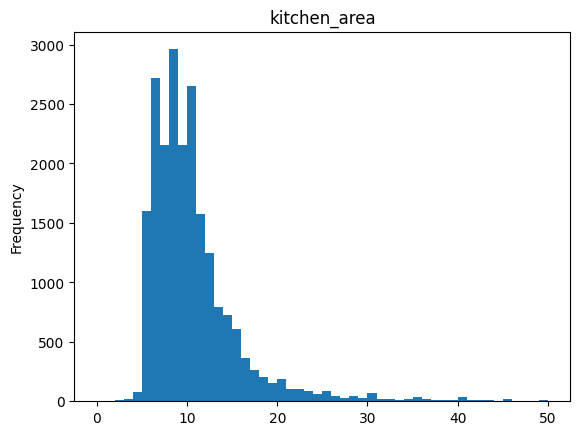

In [16]:
print(data['kitchen_area'].describe())
data.plot(y='kitchen_area',kind='hist',bins=50,title='kitchen_area',range=(0,50),legend=False)

As expected, entering 'kitchen_area' gaps as zeros resulted in a separate peak at zero.

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


<Axes: title={'center': 'last_price'}, ylabel='Frequency'>

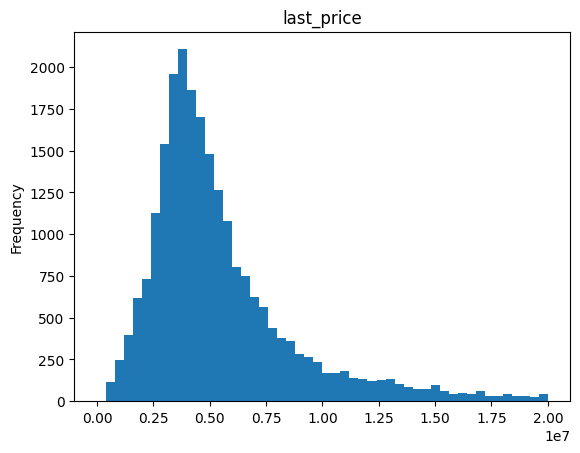

In [17]:
print(data['last_price'].describe())
data.plot(y='last_price',kind='hist',bins=50,title='last_price',range=(0,2e7),legend=False)

Normal distribution

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


<Axes: title={'center': 'rooms'}, ylabel='Frequency'>

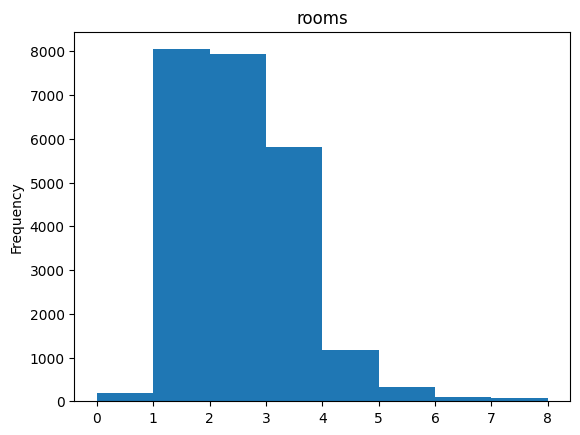

In [18]:
print(data['rooms'].describe())
data.plot(y='rooms',kind='hist',bins=8,title='rooms',range=(0,8),legend=False)

Most apartments have from 1 to 3 rooms.

count    14504.000000
mean         2.727845
std          0.292985
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max          8.300000
Name: ceiling_height, dtype: float64


<Axes: title={'center': 'ceiling_height'}, ylabel='Frequency'>

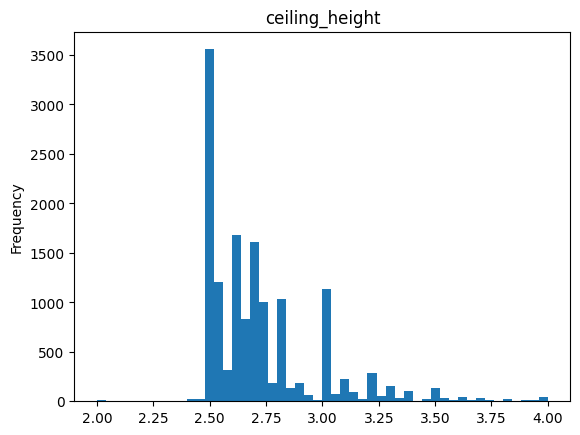

In [19]:
print(data['ceiling_height'].describe())
data.plot(y='ceiling_height',kind='hist',bins=50,title='ceiling_height',range=(2,4),legend=False)

The vast majority of apartments have ceiling heights around the median.

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


<Axes: title={'center': 'floor'}, ylabel='Frequency'>

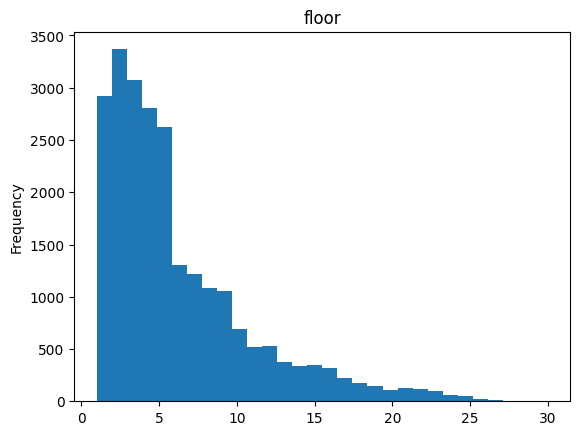

In [20]:
print(data['floor'].describe())
data.plot(y='floor',kind='hist',bins=30,title='floor',range=(1,30),legend=False)

A sharp drop in the number of apartments on floors > 5

<Axes: title={'center': 'floor_type'}, xlabel='floor_type'>

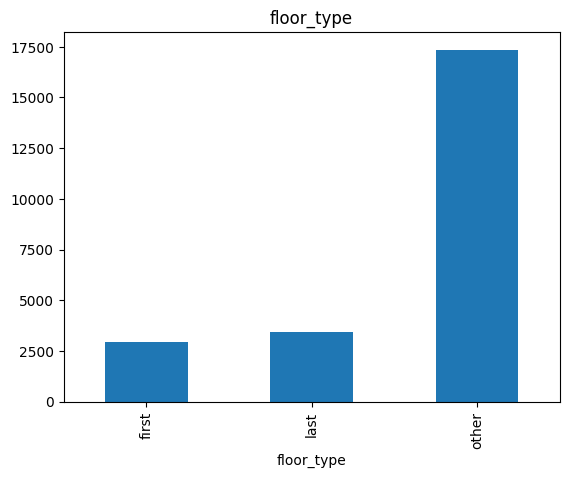

In [21]:
data.groupby('floor_type').count().plot(y='total_images',kind='bar',title='floor_type',legend=False)

Most are neither on the first nor the last floor.

count    23699.000000
mean        10.671463
std          6.595802
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


<Axes: title={'center': 'floors_total'}, ylabel='Frequency'>

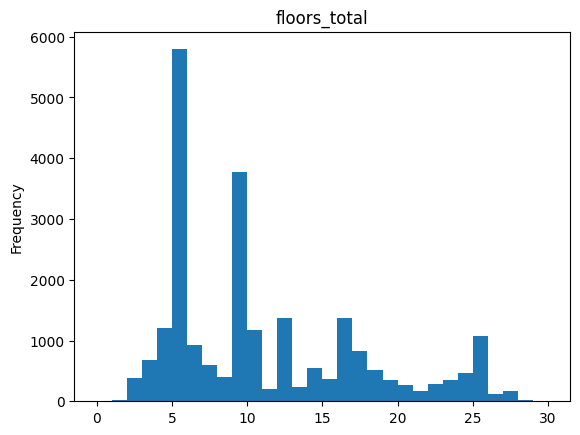

In [22]:
print(data['floors_total'].describe())
data.plot(y='floors_total',kind='hist',bins=30,title='floors_total',range=(0,30),legend=False)

No specific pattern is observed, two peaks of 5- and 9-story buildings

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


<Axes: title={'center': 'cityCenters_nearest'}, ylabel='Frequency'>

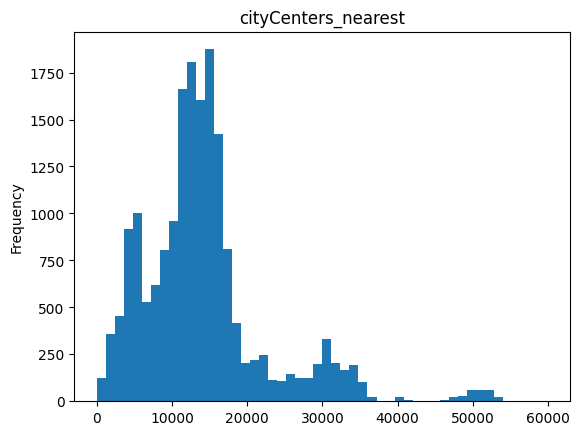

In [23]:
print(data['cityCenters_nearest'].describe())
data.plot(y='cityCenters_nearest',kind='hist',bins=50,title='cityCenters_nearest',range=(0,6e4),legend=False)

An interesting dependence with several falling peaks. Normal distribution.

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64


<Axes: title={'center': 'airports_nearest'}, ylabel='Frequency'>

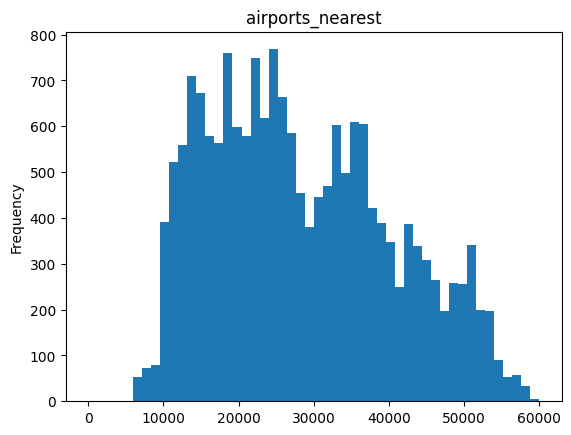

In [24]:
print(data['airports_nearest'].describe())
data.plot(y='airports_nearest',kind='hist',bins=50,title='airports_nearest',range=(0,6e4),legend=False)

Normal distribution

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


<Axes: title={'center': 'parks_nearest'}, ylabel='Frequency'>

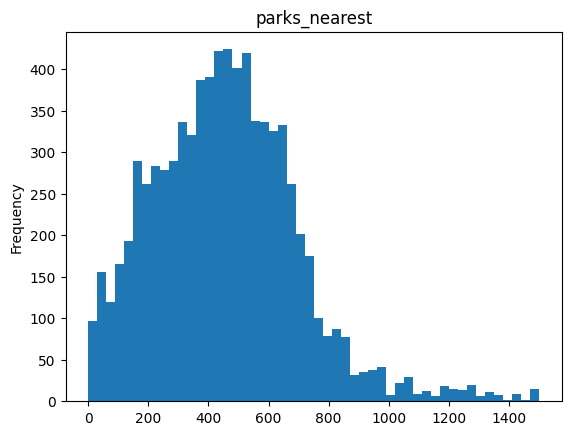

In [25]:
print(data['parks_nearest'].describe())
data.plot(y='parks_nearest',kind='hist',bins=50,title='parks_nearest',range=(0,1500),legend=False)

Normal distribution

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


<Axes: title={'center': 'days_exposition'}, ylabel='Frequency'>

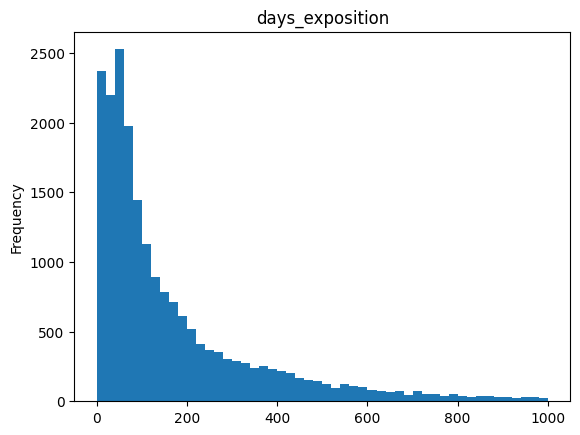

In [26]:
print(data['days_exposition'].describe())
data.plot(y='days_exposition',kind='hist',bins=50,title='days_exposition',range=(0,1000),legend=False)

Arithmetic average sale - 180 days

Average median - 95 days

Sales in 45 days or less can be considered fast, and sales in 232 days or more can be considered long.

### 3.2. Price correlation

<Axes: title={'center': 'total_area and last_price correlation: 0.654'}, xlabel='total_area', ylabel='last_price'>

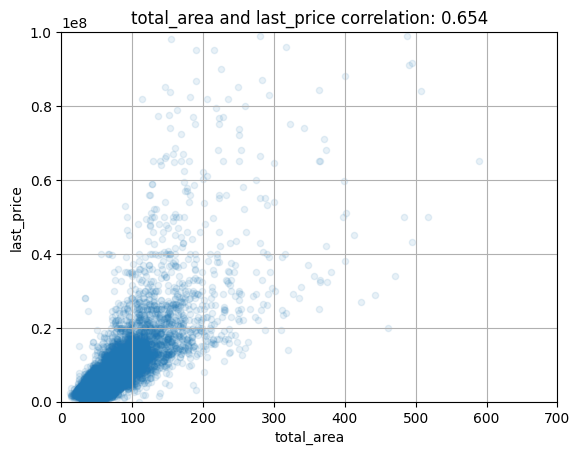

In [27]:
data.plot(x='total_area',y='last_price',kind='scatter',alpha=0.1,ylim=(0,1e8),xlim=(0,700),grid=True, 
         title=f'total_area and last_price correlation: {data["total_area"].corr(data["last_price"]):.3f}')

Initially, correlation is linear. Above ~30,000,000 last_price and ~200 total_area, either linearly or exponentially by last_price.

Average correlation

<Axes: title={'center': 'living_area and last_price correlation: 0.541'}, xlabel='living_area', ylabel='last_price'>

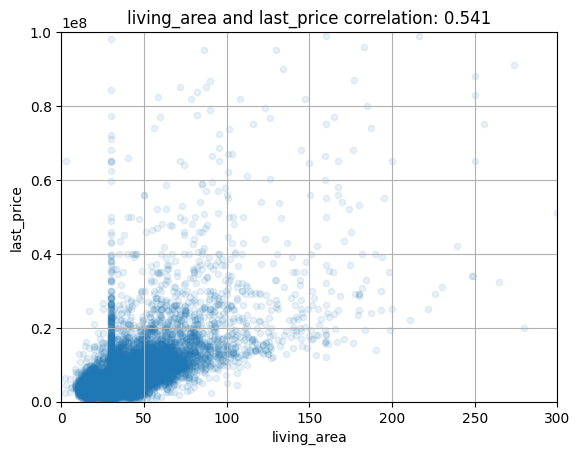

In [28]:
data.plot(x='living_area',y='last_price',kind='scatter',alpha=0.1,ylim=(0,1e8),xlim=(0,300),grid=True, 
         title=f'living_area and last_price correlation: {data["living_area"].corr(data["last_price"]):.3f}')

A similar correlation, there are no apartments with large living space and low prices.

Correlation is weaker

<Axes: title={'center': 'kitchen_area and last_price correlation: 0.520'}, xlabel='kitchen_area', ylabel='last_price'>

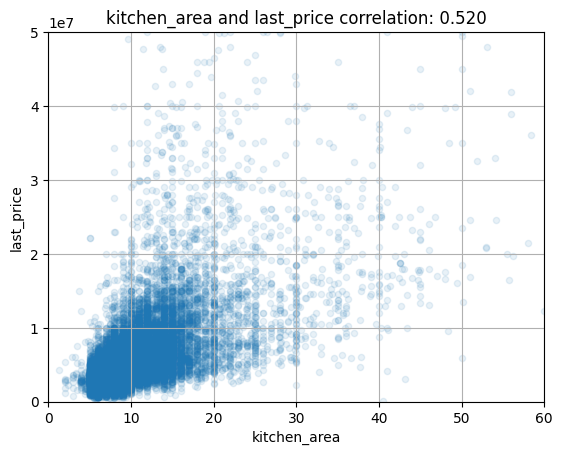

In [29]:
data.plot(x='kitchen_area',y='last_price',kind='scatter',alpha=0.1,ylim=(0,5e7),xlim=(0,60),grid=True, 
         title=f'kitchen_area and last_price correlation: {data["kitchen_area"].corr(data["last_price"]):.3f}')

General correlation: price increases with increasing kitchen area.

Average correlation

<Axes: title={'center': 'rooms and last_price correlation: 0.363'}, xlabel='rooms', ylabel='last_price'>

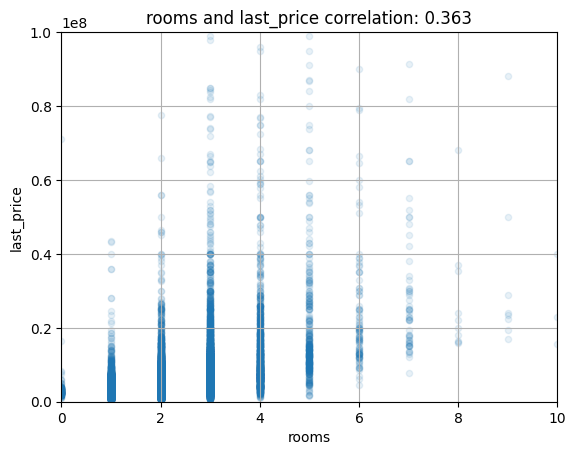

In [30]:
data.plot(x='rooms',y='last_price',kind='scatter',alpha=0.1,ylim=(0,1e8),xlim=(0,10),grid=True, 
         title=f'rooms and last_price correlation: {data["rooms"].corr(data["last_price"]):.3f}')

Weak correlation

<Axes: xlabel='floor_type', ylabel='last_price'>

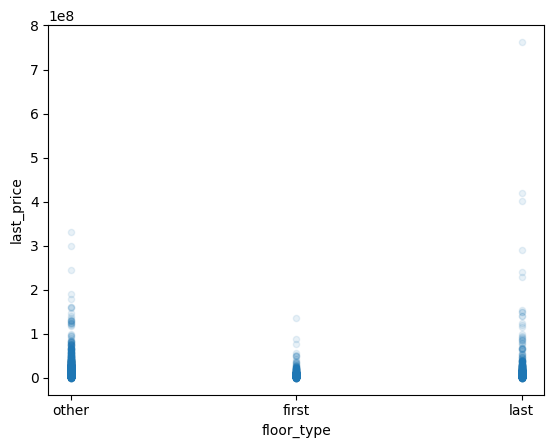

In [31]:
data.plot(x='floor_type',y='last_price',kind='scatter',alpha=0.1)

It can be seen that the price for an apartment on the ground floor is on average lower.

### 3.3. Top 10 by entries

In [32]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,15721,5500000.0
поселок Мурино,556,3400000.0
Кудрово,472,3890000.0
поселок Шушары,440,3950000.0
Всеволожск,398,3450000.0
Пушкин,369,5180000.0
Колпино,338,3600000.0
поселок Парголово,327,4100000.0
Гатчина,307,3100000.0


Of the top 10, the highest cost per square meter is St. Petersburg, the lowest is Vyborg

### 3.4. Average price per kilometer in St. Petersburg

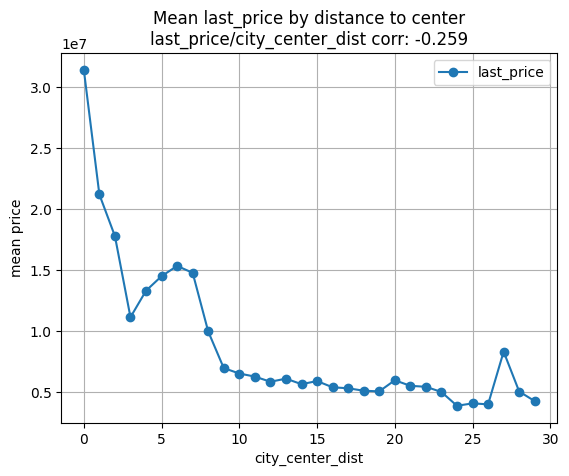

In [33]:
cor = (
data[data['locality_name'] == 'Санкт-Петербург']['last_price']
.corr(data[data['locality_name'] == 'Санкт-Петербург']['city_center_dist'])
)

table = (
    pd.pivot_table(data[data['locality_name'] == 'Санкт-Петербург'],
                  values='last_price',
                  index='city_center_dist',
                  aggfunc='mean')
    .plot(style='o-',grid=True, title = f'Mean last_price by distance to center\nlast_price/city_center_dist corr: {cor:.3f}',
                  ylabel='mean price')
)


The general correlation is a decrease with increasing distance from the center. Two anomalous peaks at 6 and 27 kilometers, most likely associated with local features.

Correlation function, as expected, indicates a weak inverse relationship.
# 3. General conclusion
Retrieved data from the file real_estate_data.csv. Two types of data are checked for missing values, outliers, data types, and duplicates.

The data was processed and new columns were added: area_price, weekday, month, year, floor_type, city_center_dist.

Data analysis was carried out. The meeting frequencies of total_area, living_area, kitchen_area, etc. were studied. The data obtained correspond to reality, most show a normal distribution.

The speed of apartment sales was assessed and relatively quick and long sales were determined, which amounted to 45 and 232 days, respectively.

Various factors influencing the price of an apartment have been studied. The main factor was the total area. Average prices per unit area were found for the 10 most popular localities. The maximum is 115,000 for St. Petersburg and the minimum is 58,000 for Vyborg.

The dependence of the price of an apartment on the distance from the center for St. Petersburg has been determined - the price falls with increasing distance.

Inconsistencies were found in the ceiling_height and is_apartment column data. In the first one, almost half of the values are missing; it is worth checking the data. The second one is practically insignificant and should either be removed or the collection of information for it should be improved.